Using device: cuda

Processing 1 videos with 

[Video 1/1]: 02_06__talking_angry_couch__MKZTXQ2T.mp4
--------------------------------------------------


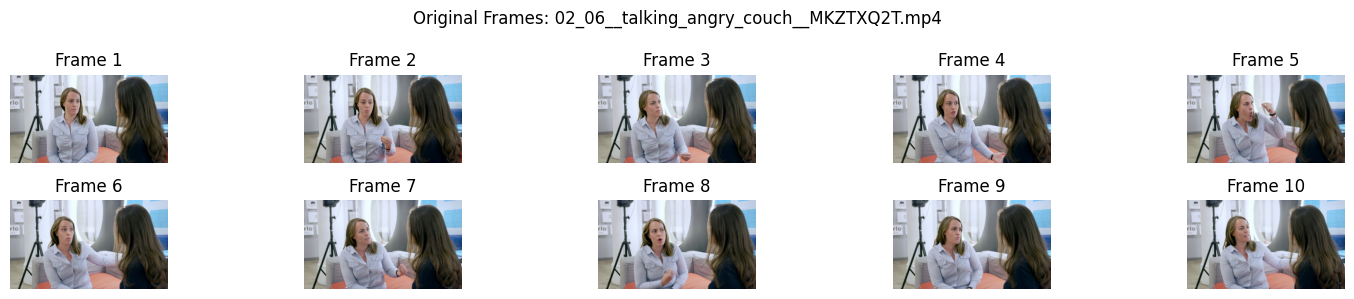

2025-04-24 23:54:42,465 - INFO - No pre-cropped frames for 02_06__talking_angry_couch__MKZTXQ2T.mp4, cropping with MTCNN


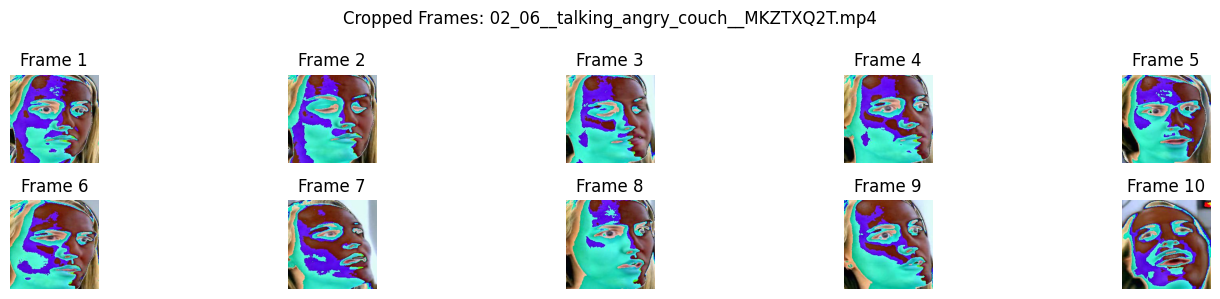


Per-Frame Confidence Scores:
Frame 1: Fake Probability=0.5103, Confidence=0.5103, MTCNN Prob=1.0000
Frame 2: Fake Probability=0.5103, Confidence=0.5103, MTCNN Prob=1.0000
Frame 3: Fake Probability=0.5103, Confidence=0.5103, MTCNN Prob=1.0000
Frame 4: Fake Probability=0.5103, Confidence=0.5103, MTCNN Prob=1.0000
Frame 5: Fake Probability=0.5103, Confidence=0.5103, MTCNN Prob=1.0000
Frame 6: Fake Probability=0.5103, Confidence=0.5103, MTCNN Prob=1.0000
Frame 7: Fake Probability=0.5103, Confidence=0.5103, MTCNN Prob=1.0000
Frame 8: Fake Probability=0.5103, Confidence=0.5103, MTCNN Prob=1.0000
Frame 9: Fake Probability=0.5103, Confidence=0.5103, MTCNN Prob=1.0000
Frame 10: Fake Probability=0.5103, Confidence=0.5103, MTCNN Prob=1.0000

Video Prediction: Fake
Probability: 0.5093 (50.93%)
Confidence: 0.5093 (50.93%)


In [7]:
# Required imports
import torch
import torch.nn as nn
from torch.cuda.amp import autocast
import torchvision.transforms as transforms
import numpy as np
import logging
import timm
import os
from facenet_pytorch import MTCNN
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize MTCNN for face detection
mtcnn = MTCNN(image_size=224, margin=20, device=device)

# Define DeepFakeDetector model (unchanged)
class DeepFakeDetector(nn.Module):
    def __init__(self, frame_count=10, pretrained=False):
        super(DeepFakeDetector, self).__init__()
        self.xception = timm.create_model('xception', pretrained=pretrained)
        num_ftrs = self.xception.fc.in_features
        self.xception.fc = nn.Linear(num_ftrs, 1024)
        self.bilstm = nn.LSTM(1024, 512, num_layers=2, batch_first=True, bidirectional=True, dropout=0.4)
        self.attention = nn.Sequential(
            nn.Linear(512 * 2, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
            nn.Softmax(dim=1)
        )
        self.dropout = nn.Dropout(0.6)
        self.fc1 = nn.Linear(512 * 2, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x, return_frame_features=False):
        batch, frames, c, h, w = x.size()
        features = []
        for i in range(frames):
            frame = x[:, i, :, :, :]
            feat = self.xception(frame)
            features.append(feat)
        sequence = torch.stack(features, dim=1)
        if return_frame_features:
            frame_logits = torch.stack([self.fc2(self.fc1(feat)) for feat in features], dim=1).squeeze(-1)
        lstm_out, _ = self.bilstm(sequence)
        attention_weights = self.attention(lstm_out)
        context = torch.sum(attention_weights * lstm_out, dim=1)
        x = self.dropout(context)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        if return_frame_features:
            return x, frame_logits
        return x


# Function to extract frames from video
def extract_frames(video_path, num_frames=10):
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            logger.error(f"Could not open video file: {video_path}")
            return None
        
        frames = []
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if frame_count <= 0:
            logger.error(f"No frames detected in video: {video_path}")
            return None
        
        # Calculate frame interval to extract evenly spaced frames
        interval = max(1, frame_count // num_frames)
        
        for i in range(min(num_frames, frame_count)):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i * interval)
            ret, frame = cap.read()
            if not ret:
                break
            # Convert BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Convert to PIL Image
            frame = Image.fromarray(frame)
            frames.append(frame)
        
        cap.release()
        
        if len(frames) < num_frames:
            logger.warning(f"Only extracted {len(frames)} frames from {video_path}")
            # Pad with last frame if needed
            while len(frames) < num_frames:
                frames.append(frames[-1] if frames else None)
        
        return frames
    except Exception as e:
        logger.error(f"Error extracting frames from {video_path}: {str(e)}")
        return None

# Function to extract and crop faces from a single video
def extract_and_crop_faces(video_path, output_dir, frame_count=10):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_idxs = np.linspace(0, total_frames-1, frame_count).astype(int)

    os.makedirs(output_dir, exist_ok=True)

    count = 0
    frame_num = 0
    with torch.no_grad():
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            if count in frame_idxs:
                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                pil_img = Image.fromarray(rgb)
                face = mtcnn(pil_img)
                if face is not None:
                    face = transforms.ToPILImage()(face)
                    face.save(os.path.join(output_dir, f"frame_{frame_num:03d}.jpg"))
                    frame_num += 1
            count += 1
            if frame_num >= frame_count:
                break
    cap.release()
    return frame_num == frame_count

# Function to load cropped frames from directory
def load_cropped_frames(video_name, label, base_dir='cropped_faces', frame_count=10):
    video_dir = os.path.join(base_dir, label, os.path.splitext(video_name)[0])
    if not os.path.exists(video_dir):
        return None
    frame_files = sorted([f for f in os.listdir(video_dir) if f.endswith('.jpg')])
    if len(frame_files) < frame_count:
        logger.warning(f"Video {video_name} has only {len(frame_files)} cropped frames, repeating last frame")
        frame_files += [frame_files[-1]] * (frame_count - len(frame_files))
    frames = []
    for i in range(frame_count):
        frame_path = os.path.join(video_dir, frame_files[i])
        try:
            frame = Image.open(frame_path).convert('RGB')
            frames.append(frame)
        except Exception as e:
            logger.error(f"Error loading frame {frame_path}: {str(e)}")
            frame = Image.new('RGB', (224, 224), (0, 0, 0))
            frames.append(frame)
    return frames

# Function to crop faces using MTCNN (fallback if cropped frames not pre-saved)
def crop_face(frame):
    try:
        frame_np = np.array(frame)
        boxes, probs = mtcnn.detect(frame_np)
        if boxes is not None and len(boxes) > 0:
            x, y, x2, y2 = map(int, boxes[0])
            x, y = max(0, x), max(0, y)
            cropped = frame.crop((x, y, x2, y2))
            return cropped, probs[0]
        else:
            logger.warning("No faces detected, using original frame")
            return frame, 0.0
    except Exception as e:
        logger.warning(f"Face detection failed: {str(e)}, using original frame")
        return frame, 0.0

# Function to display frames
def display_frames(frames, title, frame_count=10):
    plt.figure(figsize=(15, 3))
    for i in range(min(frame_count, len(frames))):
        plt.subplot(2, 5, i + 1)
        plt.imshow(frames[i])
        plt.title(f"Frame {i+1}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Modified predict_video
def predict_video(model, video_path, transform, frame_count=10, cropped_base='cropped_faces'):
    model.eval()
    video_name = os.path.basename(video_path)
    frames = extract_frames(video_path, frame_count)  # Use existing extract_frames
    if frames is None:
        logger.error(f"Failed to process video: {video_path}")
        return None
    
    # Display original frames
    display_frames(frames, f"Original Frames: {video_name}")
    
    # Try loading pre-cropped frames
    cropped_frames = None
    mtcnn_probs = [0.0] * frame_count
    for label in ['REAL', 'FAKE']:
        cropped_frames = load_cropped_frames(video_name, label, cropped_base, frame_count)
        if cropped_frames:
            mtcnn_probs = [1.0] * frame_count  # Assume pre-cropped frames are valid
            break
    
    # Fallback to MTCNN cropping if not pre-cropped
    if not cropped_frames:
        logger.info(f"No pre-cropped frames for {video_name}, cropping with MTCNN")
        output_dir = os.path.join(cropped_base, 'UNKNOWN', os.path.splitext(video_name)[0])
        if extract_and_crop_faces(video_path, output_dir, frame_count):
            cropped_frames = load_cropped_frames(video_name, 'UNKNOWN', cropped_base, frame_count)
            mtcnn_probs = [1.0] * frame_count
        else:
            cropped_frames = []
            mtcnn_probs = []
            for frame in frames:
                cropped, prob = crop_face(frame)
                cropped_frames.append(cropped)
                mtcnn_probs.append(prob)
    
    # Display cropped frames
    if cropped_frames:
        display_frames(cropped_frames, f"Cropped Frames: {video_name}")
    
    # Process frames for model
    try:
        processed_frames = [transform(frame) for frame in cropped_frames]
        frames_tensor = torch.stack(processed_frames).unsqueeze(0).to(device)
    except Exception as e:
        logger.error(f"Error preprocessing frames for {video_path}: {str(e)}")
        return None
    
    with torch.no_grad():
        with autocast():
            outputs, frame_logits = model(frames_tensor, return_frame_features=True)
            if torch.isnan(outputs).any() or torch.isnan(frame_logits).any():
                logger.warning(f"NaN detected in outputs for {video_path}, replacing with 0.0")
                outputs = torch.where(torch.isnan(outputs), torch.tensor(0.0, device=outputs.device), outputs)
                frame_logits = torch.where(torch.isnan(frame_logits), torch.tensor(0.0, device=frame_logits.device), frame_logits)
            outputs = torch.clamp(outputs, min=-1e9, max=1e9)
            frame_logits = torch.clamp(frame_logits, min=-1e9, max=1e9)
            pred_prob = torch.sigmoid(outputs.squeeze()).cpu().item()
            frame_probs = torch.sigmoid(frame_logits.squeeze()).cpu().numpy()
            frame_probs = np.clip(frame_probs, 1e-7, 1 - 1e-7)
    
    pred_label = 1 if pred_prob >= 0.5 else 0
    confidence = pred_prob if pred_label == 1 else (1 - pred_prob)
    
    return {
        'video_path': video_path,
        'pred_label': pred_label,
        'pred_prob': pred_prob,
        'confidence': confidence,
        'original_frames': frames,
        'cropped_frames': cropped_frames,
        'frame_probs': frame_probs,
        'mtcnn_probs': mtcnn_probs
    }

# Modified process_multiple_videos
def process_multiple_videos(video_paths, threshold=None, cropped_base='cropped_faces'):
    model = DeepFakeDetector(frame_count=10, pretrained=False).to(device)
    model_path = 'best_deepfake_detector_xception_resnet_bilstm.pth'
   

    augmentation_transforms = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    results = []
    print(f"\n{'='*50}")
    print(f"Processing {len(video_paths)} videos with {'' if threshold is None else f'threshold={threshold}'}")
    print(f"{'='*50}")
    
    for i, video_path in enumerate(video_paths):
        if not os.path.isfile(video_path):
            print(f"Error: Video not found at {video_path}")
            continue
        
        print(f"\n[Video {i+1}/{len(video_paths)}]: {os.path.basename(video_path)}")
        print("-" * 50)
        
        result = predict_video(model, video_path, augmentation_transforms, frame_count=10, cropped_base=cropped_base)
        
        if result:
            if threshold is not None:
                result['pred_label'] = 1 if result['pred_prob'] >= threshold else 0
                result['threshold_used'] = threshold
            results.append(result)
            prediction = 'Fake' if result['pred_label'] == 1 else 'Real'
            
            # Print per-frame confidence scores
            print("\nPer-Frame Confidence Scores:")
            for j, (frame_prob, mtcnn_prob) in enumerate(zip(result['frame_probs'], result['mtcnn_probs'])):
                frame_confidence = frame_prob if frame_prob >= 0.5 else (1 - frame_prob)
                print(f"Frame {j+1}: Fake Probability={frame_prob:.4f}, Confidence={frame_confidence:.4f}, MTCNN Prob={mtcnn_prob:.4f}")
            
            # Print video-level results
            print(f"\nVideo Prediction: {prediction}")
            print(f"Probability: {result['pred_prob']:.4f} ({result['pred_prob']*100:.2f}%)")
            print(f"Confidence: {result['confidence']:.4f} ({result['confidence']*100:.2f}%)")
            if threshold is not None:
                print(f"Custom threshold: {threshold}")
        else:
            print(f"Error: Failed to process video {video_path}")
    
    return results

# Example usage
video_paths = [
    '02_06__talking_angry_couch__MKZTXQ2T.mp4',
]
results = process_multiple_videos(video_paths)